This notebook was the google-stock-rnn tutorial.
Deep Learning for Predicting Stock Prices
Aditya Gogoi


https://github.com/thushv89/datacamp_tutorials

- https://github.com/thushv89/datacamp_tutorials/blob/master/Reviewed/lstm_stock_market_prediction.ipynb
- https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [2]:
!pip install keras
!pip install tensorflow==2.1.0

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached tensorflow-2.1.0-cp37-cp37m-manylinux2010_x86_64.whl (421.8 MB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
Processing /home/jovyan/.cache/pip/wheels/cc/af/1a/498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e/absl_py-0.9.0-py3-none-any.whl
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
Processing /home/jovyan/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3/gast-0.2.

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,198.5,187.0,198.0,187.0,12694200.0,137.609299
2014-01-03,196.0,186.5,187.0,196.0,16987100.0,144.232224
2014-01-06,203.0,191.0,195.0,201.0,10294700.0,147.911621
2014-01-07,210.0,200.0,205.0,210.0,11479200.0,154.534515
2014-01-08,210.0,203.0,208.0,206.0,13653100.0,151.591019


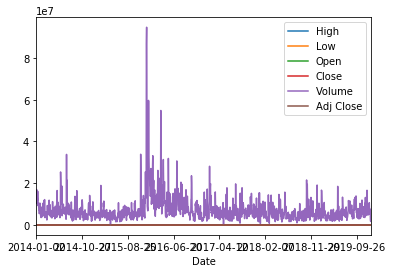

In [25]:
DATA_HOME = os.path.join("..", "historical")
# Pilot 10 stocks (first 10 stocks alphabetical)
symbols = ["ADVANC","BTS"]
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["ADVANC"]
df.index
df = df['2014-01-01':'2019-12-31'] # Pickout study period: 2015-2019. 1219 days
df.plot()
df.head()

In [28]:
from talib.abstract import *

daily = df['2014-01-01':'2019-12-31']

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily["SMA"] = SMA(inputs, timeperiod=25).tolist()
daily["WMA"] = WMA(inputs).tolist()
daily["ADOSC"] = ADOSC(inputs).tolist()
daily["ATR"] = ATR(inputs).tolist()
daily["RSI"] = RSI(inputs).tolist()
daily["AD"] = AD(inputs).tolist()

daily = daily.dropna()

daily

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD
Date,,,,,,,,,,,,
2014-02-12,215.0,210.0,210.0,214.0,7204000.0,157.478012,210.10,210.405376,4.086292e+05,6.083446,61.439766,2.997581e+07
2014-02-13,216.0,213.0,214.0,215.0,4674700.0,158.213928,210.58,210.830108,1.294266e+06,5.863200,62.273511,3.153405e+07
2014-02-17,222.0,214.0,216.0,222.0,8395400.0,163.365067,211.48,211.646237,4.210176e+06,6.015829,67.560940,3.992945e+07
2014-02-18,221.0,217.0,220.0,219.0,6289500.0,161.157425,211.88,212.212903,5.020304e+06,5.943270,63.456249,3.992945e+07
2014-02-19,224.0,214.0,219.0,217.0,8990800.0,159.685638,212.08,212.611828,3.751046e+06,6.233036,60.804024,3.633313e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,221.0,214.0,220.0,215.0,6880100.0,211.406570,216.72,215.875269,2.090767e+06,5.723004,46.672607,-4.704758e+08
2019-12-25,216.0,212.0,213.0,215.0,2423600.0,211.406570,216.12,215.606452,1.593053e+06,5.599932,46.672607,-4.692640e+08
2019-12-26,216.0,214.0,216.0,215.0,1685300.0,211.406570,215.64,215.365591,1.244620e+06,5.342794,46.672607,-4.692640e+08


In [41]:
# Drop unused columns
df = df.drop(columns=["Adj Close", "Volume"])

df.iloc[:,2:3].values # Get Open price. The 2:3 slice the "Open" column

array([[198.],
       [187.],
       [195.],
       ...,
       [216.],
       [216.],
       [215.]])

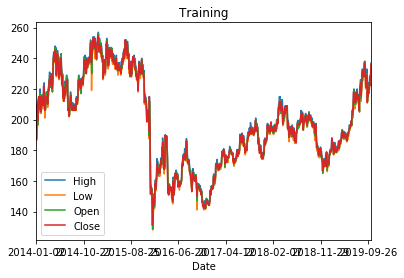

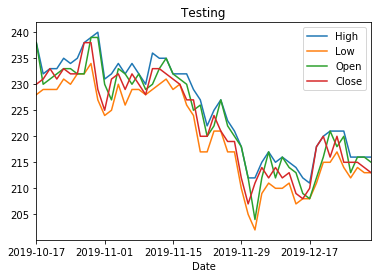

In [42]:

training = df[:-50]
testing = df[-50:]
training.plot(title="Training")
testing.plot(title="Testing")

In [6]:
trainset = training.iloc[:,2:3].values
trainset
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)
training_scaled

x_train = training_scaled[0:len(training) - 1]
y_train = training_scaled[1:len(training)] # Start from day 1

In [11]:
x_train.shape, y_train.shape

((1168, 1), (1168, 1))

In [44]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [45]:
regressor = Sequential()

# regressor.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))
regressor.add(LSTM(units = 4, input_shape = (x_train.shape[1], 1)))

In [14]:
# regressor.add(Dropout(0.2))

In [15]:
# regressor.add(LSTM(units = 50,return_sequences = True))
# regressor.add(Dropout(0.2))

In [16]:
# regressor.add(LSTM(units = 50,return_sequences = True))
# regressor.add(Dropout(0.2))

In [17]:
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))

In [18]:
regressor.add(Dense(units = 1))

In [49]:
regressor.model.count_params()

96

In [50]:
regressor.model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_2',
    'trainable': True,
    'batch_input_shape': (None, 1, 1),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 4,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

In [19]:
regressor.compile(optimizer = 'adam',loss = 'mean_squared_error')

In [20]:
history = regressor.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100
1168/1168 [==============================] - 1s 812us/step - loss: 0.2021
Epoch 2/100
1168/1168 [==============================] - 0s 84us/step - loss: 0.1327
Epoch 3/100
1168/1168 [==============================] - 0s 80us/step - loss: 0.0821
Epoch 4/100
1168/1168 [==============================] - 0s 94us/step - loss: 0.0492
Epoch 5/100
1168/1168 [==============================] - 0s 91us/step - loss: 0.0304
Epoch 6/100
1168/1168 [==============================] - 0s 81us/step - loss: 0.0210
Epoch 7/100
1168/1168 [==============================] - 0s 88us/step - loss: 0.0169
Epoch 8/100
1168/1168 [==============================] - 0s 87us/step - loss: 0.0151
Epoch 9/100
1168/1168 [==============================] - 0s 91us/step - loss: 0.0140
Epoch 10/100
1168/1168 [==============================] - 0s 83us/step - loss: 0.0131
Epoch 11/100
1168/1168 [==============================] - 0s 87us/step - loss: 0.0122
Epoch 12/100
1168/1168 [==============================] - 0s 8

1168/1168 [==============================] - 0s 85us/step - loss: 5.2980e-04
Epoch 93/100
1168/1168 [==============================] - 0s 112us/step - loss: 5.3374e-04
Epoch 94/100
1168/1168 [==============================] - 0s 105us/step - loss: 5.3221e-04
Epoch 95/100
1168/1168 [==============================] - 0s 107us/step - loss: 5.3006e-04
Epoch 96/100
1168/1168 [==============================] - 0s 107us/step - loss: 5.3248e-04
Epoch 97/100
1168/1168 [==============================] - 0s 104us/step - loss: 5.2823e-04
Epoch 98/100
1168/1168 [==============================] - 0s 107us/step - loss: 5.3008e-04
Epoch 99/100
1168/1168 [==============================] - 0s 100us/step - loss: 5.3081e-04
Epoch 100/100
1168/1168 [==============================] - 0s 107us/step - loss: 5.3118e-04


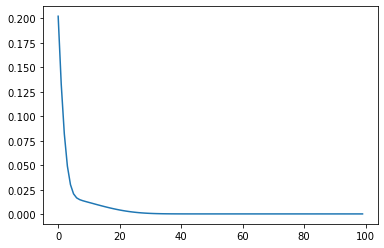

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])


In [54]:
regressor.input

<tf.Tensor 'lstm_2_input:0' shape=(None, 1, 1) dtype=float32>

In [22]:
real_stock_price = training.iloc[:,2:3].values

In [23]:
dataset_total = pd.concat((training, testing),axis = 0)
dataset_total

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-05,254.0,247.0,252.0,249.0,5232400.0,193.482346
2015-01-06,250.0,245.0,246.0,247.0,4386200.0,191.928238
2015-01-07,253.0,240.0,246.0,253.0,11060300.0,196.590500
2015-01-08,252.0,248.0,251.0,250.0,6530700.0,194.259384
2015-01-09,251.0,248.0,251.0,248.0,4615500.0,192.705292
...,...,...,...,...,...,...
2019-12-24,221.0,214.0,220.0,215.0,6880100.0,211.406570
2019-12-25,216.0,212.0,213.0,215.0,2423600.0,211.406570
2019-12-26,216.0,214.0,216.0,215.0,1685300.0,211.406570


NameError: name 'x_test' is not defined

In [29]:
inputs = dataset_total[len(dataset_total) - len(testing) - hp:].values
inputs

NameError: name 'hp' is not defined

In [ ]:
inputs = inputs.reshape(-1,1)

In [ ]:
inputs

In [ ]:
inputs = sc.transform(inputs)
inputs.shape

In [ ]:
x_test = []
for i in range(60,185):
    x_test.append(inputs[i-60:i,0])

In [ ]:
x_test = np.array(x_test)
x_test.shape

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

In [ ]:
predicted_price = regressor.predict(x_test)

In [ ]:
predicted_price = sc.inverse_transform(predicted_price)
predicted_price

In [ ]:
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()